## (&#x1F4D7;) Cookbook: abba-baba introgression stats

The `ipyrad.analysis` Python module includes functions to calculate abba-baba admixture statistics, as well as several variants of these measures, and to perform signifance tests. The code in this notebook is all Python, which you can copy/paste into an IPython terminal to execute, or, preferably, run in a Jupyter notebook like this one. See the other analysis cookbooks for [instructions](http://ipyrad.readthedocs.io/analysis.html) on using Jupyter notebooks. All of the software required for this tutorial is installed with `ipyrad`. 

In [1]:
## start by loading several Python libraries
import ipyrad.analysis.baba as baba
import ipyrad as ip
import ipyparallel as ipp

## optional
import numpy as np
import pandas as pd

### Connect to `ipyparallel` cluster
This requres that you start an `ipcluster` instance running in a separate terminal. See the ipyparallel docs, or [our tutorial on using ipyparallel]() for more details on how to properly set this up. If you do not have an `ipcluster` instance running this will raise a TimeoutError after a few seconds. 


In [2]:
## connect to ipcluster instance 
ipyclient = ipp.Client()

## print info about your connection
print ip.cluster_info(ipyclient)

  host compute node: [4 cores] on oud


### Load a finished assembly
Here we don't do much with the Assembly object other than access the location of the .loci file from it. It could be useful, however, in other ways such as providing access to Sample names (in the .samples attribute) or to the mapping of Sample names to Populations (in the .populations attribute). 

In [4]:
## use the load command to get all stats and file paths
data = ip.load_json("cli/cli.json")

## loci input file
locifile = data.outfiles.loci

  loading Assembly: cli
  from saved path: ~/Documents/ipyrad/tests/cli/cli.json


### Create input arguments for abba-baba test

In [5]:
## a dictionary with [required] key names 
## optional: additional 'p5' key for 5-taxon tests.
test = {
    'p4': ["3L_0", "3J_0", "3K_0"], 
    'p3': ["2E_0", "2F_0"],
    'p2': ["1D_0"],
    'p1': ["1A_0", "1B_0", "1C_0"],
}

## optional: dict for min samples per taxon (default=1 per tax)
## used to filter loci for inclusion in data set
mindict = {
    'p4': 2,
    'p3': 2,
    'p2': 1, 
    'p1': 2,
}

### Run a single test
This calculates the D-statistic across 1000 bootstrap replicates in which `nloci` are resampled with replacement. The number of loci (`nloci`) is often a subset of the total number of loci, since only loci with data for at least one Sample in all four lineages can be used in the test. If multiple Samples are listed for a taxon (e.g., "P1"), then only one needs to contain data, by default, to have sufficient sampling. However, the argument `mindict` can be used to set a higher minimum coverage. If a integer is entered then that value will be the minimum coverage for all lineages, or a dictionary can be entered with different values for each lineage. 

TODO: return nloci

In [6]:
## run with default mindict=1
stats, boots = baba.baba(handle, test, mindict=1, nboots=1000)
print "mindict=1\n", stats

## run with default mindict=1
stats, boots = baba.baba(handle, test, mindict=mindict, nboots=1000)
print "\nmindict={'p4':2, 'p3':2, 'p2':1, 'p1':2}\n", stats

mindict=1
                  0
dstat     -0.017878
bootmean  -0.022677
bootstd    0.220283
abba      11.444444
baba      11.861111
Z          0.102944

mindict={'p4':2, 'p3':2, 'p2':1, 'p1':2}
                  0
dstat     -0.017878
bootmean  -0.022741
bootstd    0.224333
abba      11.444444
baba      11.861111
Z          0.101373


### Run many tests in batch-mode

In [7]:
## multiple tests are entered as a list of dictionaries
tests = [test, test, test, test]

## the last argument is the ipcluster client
stats, boots = baba.batch(handle, tests, mindict, 1000, ipyclient)
print stats

  [####################] 100%  calculating D-stats  | 0:00:01 |  

      dstat  bootmean   bootstd       ABBA       BABA         Z
0 -0.017878 -0.016872  0.214390  11.444444  11.861111  0.078697
1 -0.017878 -0.024173  0.223176  11.444444  11.861111  0.108314
2 -0.017878 -0.026983  0.223939  11.444444  11.861111  0.120494
3 -0.017878 -0.009503  0.204265  11.444444  11.861111  0.046525


## Simulation scenario of 12 taxon tree

Simulated data on a 12 taxon tree. Big split: (A,B,C,D) ((E,F,G,H),(I,J,K,L)). Gene flow occurs from IJ -> H, and from C->B. 



In [12]:
import msprime as ms
import ete3 as ete
tree = baba.Tree()

In [13]:
nreps = 10
admix = None
Ns = 5e5
gen = 20

In [51]:
## todo: rotate tip names 90 deg. & offset & show idx for all
## also add hover stats for [edge.length, edge.Ns, node.idx, node.name]
print tree.draw(width=600, height=300)

(<toyplot.canvas.Canvas object at 0x7fbde56ef150>, <toyplot.coordinates.Cartesian object at 0x7fbde4aee190>)


0 1 2 3 4 5 6 7 8 9 10 a b c d e f g h i j k l

In [20]:
## 
Taus = np.array(list(set(tree.verts[:, 1]))) * 1e4 * gen

## Population IDs correspond to their indexes in pop config
ntips = len(tree.tree)
pop_config = [
    ms.PopulationConfiguration(sample_size=2, initial_size=Ns)
    for i in range(ntips):
        pass
]

## migration matrix all zeros init
migmat = np.zeros((ntips, ntips)).tolist()

## a list for storing demographic events
demog = []


In [34]:
## coalescent times
coals = sorted(list(set(tree.verts[:, 1])))[1:]
coals

[1.0, 2.0, 3.0, 4.0, 5.0]

In [38]:
np.where(tree.verts[:, 1] == coals[0])[0]

array([ 3,  7, 10])

In [47]:
[i.idx for i in tree.tree.get_descendants() if i.is_leaf()]

[14, 13, 18, 22, 11, 12, 17, 21, 15, 16, 19, 20]

In [42]:
print tree.verts
print tree.edges

[[  7.125   5.   ]
 [ 10.125   3.   ]
 [  9.25    2.   ]
 [  8.5     1.   ]
 [  4.125   4.   ]
 [  6.125   3.   ]
 [  5.25    2.   ]
 [  4.5     1.   ]
 [  2.125   3.   ]
 [  1.25    2.   ]
 [  0.5     1.   ]
 [  9.      0.   ]
 [  8.      0.   ]
 [ 10.      0.   ]
 [ 11.      0.   ]
 [  5.      0.   ]
 [  4.      0.   ]
 [  6.      0.   ]
 [  7.      0.   ]
 [  1.      0.   ]
 [  0.      0.   ]
 [  2.      0.   ]
 [  3.      0.   ]]
[[ 2 13]
 [ 3 11]
 [ 3 12]
 [ 2  3]
 [ 1  2]
 [ 0  1]
 [ 5 18]
 [ 6 17]
 [ 7 15]
 [ 7 16]
 [ 6  7]
 [ 5  6]
 [ 4  5]
 [ 8 22]
 [ 9 21]
 [10 19]
 [10 20]
 [ 9 10]
 [ 8  9]
 [ 4  8]
 [ 0  4]
 [ 1 14]]


In [23]:
for node in tree.tree.traverse("postorder"):
    print node.name

d
c
a
b
3
2
1
h
g
e
f
7
6
5
l
k
i
j
10
9
8
4
0


In [7]:

def demography(nreps, Ns=500000, gen=10, mut=1e-9, mig=1e-9, scen=0):
    
    # years are in units of 1e6 years, divide to get units in generations
    Taus = (np.array([0, 1, 2, 3, 4, 5]) * 1e6) / gen

    # Migration rates C -> B and from IJ -> EF
    m_C_B = mig
    m_IJ_EF = mig
    
    # Population IDs correspond to their indexes in pop_config.
    pop_config = [
        ms.PopulationConfiguration(sample_size=2, initial_size=Ns)
        for i in range(12)]
    
    ## migration matrix all zeros time=0
    migmat = np.zeros((12, 12)).tolist()
    
    ## set up demography
    if scen:
        ## this one is INTO IJ (forward in time), and INTO C
        x = ms.MigrationRateChange(time=0., rate=m_C_B, matrix_index=(2, 1))
        y = ms.MigrationRateChange(time=Taus[1], rate=m_IJ_EF, matrix_index=(8, 4)) 

    else:
        ## this one in INTO EF (forward) and INTO B
        x = ms.MigrationRateChange(time=0, rate=m_C_B, matrix_index=(1, 2))
        y = ms.MigrationRateChange(time=Taus[1], rate=m_IJ_EF, matrix_index=(4, 8)) 
        
    #ms.MigrationRateChange(time=0., rate=m_IJ_EF, matrix_index=(9, 4)) 
    #ms.MigrationRateChange(time=0., rate=m_IJ_EF, matrix_index=(8, 4)) 

    demog = [
        ## initial migration from C -> B
        x,
        ms.MigrationRateChange(time=Taus[1], rate=0),

        # merge events at time 1 (b,a), (f,e), (j,i)
        ms.MassMigration(time=Taus[1], source=1, destination=0, proportion=1.0), 
        ms.MassMigration(time=Taus[1], source=5, destination=4, proportion=1.0), 
        ms.MassMigration(time=Taus[1], source=9, destination=8, proportion=1.0), 
        
        ## migration from IJ -> EF (backward in time)
        y,
        
        ## merge events at time 2 (c,a), (g,e), (k,i)
        ms.MassMigration(time=Taus[2], source=2, destination=0, proportion=1.0), 
        ms.MassMigration(time=Taus[2], source=6, destination=4, proportion=1.0), 
        ms.MassMigration(time=Taus[2], source=10, destination=8, proportion=1.0), 

        ## end migration at ABC and merge
        ms.MigrationRateChange(time=Taus[2], rate=0),
        ms.MassMigration(time=Taus[3], source=3, destination=0, proportion=1.0), 
        ms.MassMigration(time=Taus[3], source=7, destination=4, proportion=1.0), 
        ms.MassMigration(time=Taus[3], source=11, destination=8, proportion=1.0),   
        
        ## merge EFJH -> IJKL
        ms.MassMigration(time=Taus[4], source=8, destination=4, proportion=1.0),   
        
        ## merge ABCD -> EFJHIJKL
        ms.MassMigration(time=Taus[5], source=4, destination=0, proportion=1.0),   
    ]

    ## sim the data
    replicates = ms.simulate(
        population_configurations=pop_config,
        migration_matrix=migmat,
        demographic_events=demog,
        num_replicates=nreps,
        length=100, 
        mutation_rate=mut)
    
    return replicates

### TESTING THE SIMS

In [20]:
## introgression ij -> ef
test = {
    'p5': ['a', 'b', 'c', 'd'],
    'p4': ['k'],
    'p3': ['i', 'j'],
    'p2': ['e', 'f'],
    'p1': ['g'],
}

sims = demography(10000, Ns=1e6, mut=1e-8, mig=5e-5, gen=1, scen=1)
r, b = baba.baba(sims, test, nboots=1000)
print r

           dstat  bootmean   bootstd        abxxa        baxxa          Z
p3      0.105043  0.105103  0.008031  4347.031250  3520.593750  13.079410
p4      0.020286  0.020316  0.009568  3316.695312  3184.804688   2.120156
shared  0.507796  0.508296  0.008812  9140.445313  2983.799479  57.627364


In [19]:
sims = demography(10000, Ns=1e6, mut=1e-8, mig=5e-5, gen=1, scen=0)
r, b = baba.baba(sims, test, nboots=1000)
print r

           dstat  bootmean   bootstd       abxxa       baxxa          Z
p3      0.090130  0.090191  0.009824  4224.21875  3525.71875   9.174368
p4      0.015188  0.015300  0.009858  3294.12500  3195.56250   1.540635
shared  0.432020  0.431656  0.011232  6834.56250  2710.78125  38.463642


           dstat  bootmean   bootstd       abxxa       baxxa          Z
p3      0.090130  0.090636  0.009607  4224.21875  3525.71875   9.381222
p4      0.015188  0.015511  0.009963  3294.12500  3195.56250   1.524395
shared  0.432020  0.431724  0.011572  6834.56250  2710.78125  37.333960


### Run on sim data

In [10]:
## there should be no imbalance in this test
test = {
    'p4': ['a', 'b', 'c', 'd'],
    'p3': ['l'],
    'p2': ['k'],
    'p1': ['i', 'j'],
}
## mindict
mindict = {key: 1 for key in test}

### Run a single simulated data set

In [11]:
sims = demography(10000, Ns=1e6, mut=1e-9, mig=1e-7, gen=1)
res, boots = baba.baba(sims, test, mindict, 1000)
print res

                   0
dstat       0.003868
bootmean    0.001674
bootstd     0.037506
abba      330.539062
baba      327.992188
Z           0.044628


### 4-taxon tests

In [12]:
tests = [
    ## no introgression
    {
    'p4': ['a', 'b', 'c', 'd'],
    'p3': ['l'],
    'p2': ['j'],
    'p1': ['k'],
    }, 
    ## no introgression
    {
    'p4': ['e','f','g','h'],
    'p3': ['d'],
    'p2': ['c'],
    'p1': ['a'],
    }, 
    ## no introgression
    {
    'p4': ['h'],
    'p3': ['g'],
    'p2': ['f'],
    'p1': ['e'],
    }, 
    ## no introgression
    {
    'p4': ['a', 'b', 'c', 'd'],
    'p3': ['g'],
    'p2': ['f'],
    'p1': ['e'],
    }, 
    ## no introgression
    {
    'p4': ['a', 'b', 'c', 'd'],
    'p3': ['k'],
    'p2': ['j'],
    'p1': ['i'],
    }, 
    ## introgression 
    {
    'p4': ['a', 'b', 'c', 'd'],
    'p3': ['i', 'j'],
    'p2': ['g'],
    'p1': ['f'],
    },
    ## introgression 
    {
    'p4': ['a', 'b', 'c', 'd'],
    'p3': ['i', 'j'],
    'p2': ['g'],
    'p1': ['e'],
    },
    ## introgression 
    {
    'p4': ['a', 'b', 'c', 'd'],
    'p3': ['i', 'j'],
    'p2': ['g'],
    'p1': ['e', 'f'],
    },   
    ## introgression C->B
    {
    'p4': ['e','f','g','h'],
    'p3': ['c'],
    'p2': ['b'],
    'p1': ['a'],
    },     
    ## introgression C->B
    {
    'p4': ['i', 'j', 'k', 'l'],
    'p3': ['c'],
    'p2': ['b'],
    'p1': ['a'],
    },         
]

tests    

[{'p1': ['k'], 'p2': ['j'], 'p3': ['l'], 'p4': ['a', 'b', 'c', 'd']},
 {'p1': ['a'], 'p2': ['c'], 'p3': ['d'], 'p4': ['e', 'f', 'g', 'h']},
 {'p1': ['e'], 'p2': ['f'], 'p3': ['g'], 'p4': ['h']},
 {'p1': ['e'], 'p2': ['f'], 'p3': ['g'], 'p4': ['a', 'b', 'c', 'd']},
 {'p1': ['i'], 'p2': ['j'], 'p3': ['k'], 'p4': ['a', 'b', 'c', 'd']},
 {'p1': ['f'], 'p2': ['g'], 'p3': ['i', 'j'], 'p4': ['a', 'b', 'c', 'd']},
 {'p1': ['e'], 'p2': ['g'], 'p3': ['i', 'j'], 'p4': ['a', 'b', 'c', 'd']},
 {'p1': ['e', 'f'], 'p2': ['g'], 'p3': ['i', 'j'], 'p4': ['a', 'b', 'c', 'd']},
 {'p1': ['a'], 'p2': ['b'], 'p3': ['c'], 'p4': ['e', 'f', 'g', 'h']},
 {'p1': ['a'], 'p2': ['b'], 'p3': ['c'], 'p4': ['i', 'j', 'k', 'l']}]

### Run a batch of simulated data sets

In [13]:
## a simulation generator
sims = demography(10000, Ns=1e6, mut=1e-9, mig=1e-8, gen=250)

## pass it as first arg to batch func
r, b = baba.batch(sims, tests, nboots=1000, ipyclient=ipyclient)

  [####################] 100%  calculating D-stats  | 0:00:17 |  


      dstat  bootmean   bootstd        ABBA        BABA         Z
0  0.014837  0.014548  0.021877  335.593750  325.781250  0.665011
1 -0.060238 -0.060335  0.019935  318.109375  358.890625  3.026649
2  0.024448  0.024100  0.023544  350.937500  334.187500  1.023625
3  0.027309  0.027138  0.019682  349.734375  331.140625  1.378858
4  0.000609  0.000689  0.021841  333.687500  333.281250  0.031551
5  0.013190  0.012590  0.017985  333.671875  324.984375  0.700003
6  0.043367  0.043750  0.017947  344.906250  316.234375  2.437708
7  0.028307  0.028736  0.015103  339.289062  320.609375  1.902687
8  0.006305  0.006473  0.020380  326.687500  322.593750  0.317607
9 -0.006399 -0.005332  0.021035  322.671875  326.828125  0.253476


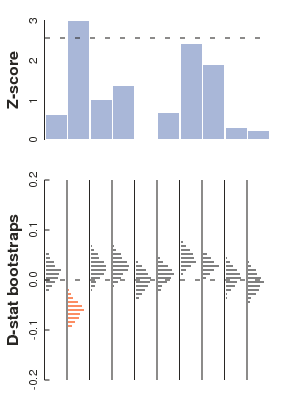

In [14]:
print r
baba.bootplot(r, b, width=300, alpha=0.01)

## Calculate 4-taxon statistics
<br>

$
    D = \frac{\Sigma(ABBA - BABA)}{\Sigma(ABBA+BABA)}
$

<br>

$
    D_p = \frac{\Sigma ~ [ p_1 ~ (1-p_2) ~ p_3 ~ (1-p_4) ] - [(1-p_1) ~ p_2 ~ p_3 ~ (1-p_4)]}      {\Sigma ~ [ p_1 ~ (1-p_2) ~ p_3 ~ (1-p_4) ] + [(1-p_1) ~ p_2 ~ p_3 ~ (1-p_4)]}
$

<br>

## Calculate 5-taxon statistics

<br>

$
    D_{12} = \frac{\Sigma(ABBBA - BABBA)}{\Sigma(ABBBA+BABBA)}
$

$
    D_{1} = \frac{\Sigma(ABBAA - BABAA)}{\Sigma(ABBAA+BABAA)}
$

$
    D_{2} = \frac{\Sigma(ABABA - BAABA)}{\Sigma(ABABA+BAABA)}
$

<br>

$
    D_{p12} = \frac 
        {\Sigma ~ [ p_1 ~ (1-p_2) ~ p_3 ~ p_4 ~ (1-p_5) ] - [(1-p_1) ~ p_2 ~ p_3 ~ p_4 ~ (1-p_5)]} 
        {\Sigma ~ [ p_1 ~ (1-p_2) ~ p_3 ~ p_4 ~ (1-p_4) ] + [(1-p_1) ~ p_2 ~ p_3 ~ p_4 ~ (1-p_5)]}
$


$
    D_{p1} = \frac 
        {\Sigma ~ [ p_1 ~ (1-p_2) ~ p_3 ~ (1-p_4) ~ (1-p_5) ] - [(1-p_1) ~ p_2 ~ p_3 ~ (1-p_4) ~ (1-p_5)]} 
        {\Sigma ~ [ p_1 ~ (1-p_2) ~ p_3 ~ (1-p_4) ~ (1-p_5) ] + [(1-p_1) ~ p_2 ~ p_3 ~ (1-p_4) ~ (1-p_5)]}
$


$
    D_{p2} = \frac 
        {\Sigma ~ [ p_1 ~ (1-p_2) ~ (1-p_3) ~ p_4 ~ (1-p_5) ] - [(1-p_1) ~ p_2 ~ (1-p_3) ~ p_4 ~ (1-p_5)]} 
        {\Sigma ~ [ p_1 ~ (1-p_2) ~ (1-p_3) ~ p_4 ~ (1-p_5) ] + [(1-p_1) ~ p_2 ~ (1-p_3) ~ p_4 ~ (1-p_5)]}
$

<br>

### Setup CLI data test

In [17]:
## a dictionary with [required] key names 
## optional: additional 'p4' key for 5-taxon tests.
test = {
    'p5': ["3L_0", "3J_0", "3K_0"], 
    'p4': ["2G_0", "2H_0"],
    'p3': ["2E_0", "2F_0"],
    'p2': ["1D_0"],
    'p1': ["1A_0", "1B_0", "1C_0"],
}

## optional: dict for min samples per taxon (default=1 per tax)
## used to filter loci for inclusion in data set
mindict = {
    'p1': 1,
    'p2': 1,
    'p3': 1, 
    'p4': 1,
    'p5': 1,
}

## loci input file
handle = data.outfiles.loci

In [18]:
## run baba.batch() for five taxa
r, b = baba.baba(handle, test, None, 1000)
print r

           dstat  bootmean   bootstd      abxxa      baxxa         Z
p3     -0.333333 -0.426138  0.505859   0.250000   0.500000  0.658945
p4      0.080460  0.072276  0.319822   1.958333   1.666667  0.251576
shared  0.005321 -0.001116  0.204465  12.465278  12.333333  0.026022


### Setup msprime data test

In [38]:
## introgression ij -> ef
test = {
    'p5': ['a', 'b', 'c', 'd'],
    'p4': ['k'],
    'p3': ['i', 'j'],
    'p2': ['e', 'f'],
    'p1': ['g'],
}

## sim and calc
sims = demography(20000, Ns=1e5, mut=1e-8, mig=1e-6, gen=1)
r, b = baba.baba(sims, test, None, 1000)

In [39]:
print r

           dstat  bootmean   bootstd         abxxa    baxxa          Z
p3      0.212910  0.212728  0.008965   5061.437500  3284.50  23.748952
p4      0.043302  0.043464  0.010466   3838.375000  3519.75   4.137329
shared  1.000000  1.000000  0.000000  30292.041667     0.00   0.000000


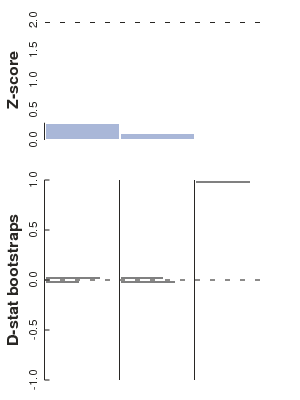

In [36]:
baba.bootplot(r, b, width=300)

In [40]:
sims = demography(20000, Ns=1e6, mut=1e-9, mig=0, gen=250, scen=1)
r, b = baba.baba(sims, test, None, 1000)
print r

           dstat  bootmean   bootstd     abxxa     baxxa         Z
p3      0.006717  0.005618  0.028301  384.0625  378.9375  0.237336
p4      0.082609  0.081418  0.140152   31.1250   26.3750  0.589423
shared  0.006858  0.006667  0.021331  683.6250  674.3125  0.321494


In [52]:
#arr[:3, :, :5]
r,b = runit(20000, Ns=500000, mut=1e-8, mig=1e-7, gen=200, nboots=1000, test=tt, scen=0)

In [ ]:
print r

In [51]:
print r

        dstat  bootmean   bootstd       abba      baba         Z
P3   0.030719  0.030396  0.006319  6305.8750  5930.000  4.861042
P4  -0.020440 -0.014946  0.087674   155.7500   162.250  0.233139
P34 -0.002844 -0.002724  0.006765  7089.6875  7130.125  0.420368


In [115]:
r, b = runit(20000, 100000, 1e6, 20, 1000, tt, scen=0)
print r

        dstat  bootmean   bootstd         abba      baba           Z
P3   0.970319  0.970239  0.003995  2103.523438   31.6875  242.854941
P4  -0.009879 -0.010505  0.045515   239.593750  244.3750    0.217053
P34 -0.011613 -0.012013  0.028077   468.125000  479.1250    0.413592


In [116]:
r, b = runit(100000, 100000, 1e6, 20, 1000, tt, scen=1)
print r

        dstat  bootmean   bootstd       abba        baba          Z
P3   0.792902  0.793191  0.009480  1982.3125  228.976562  83.639490
P4  -0.165720 -0.161074  0.117543    25.2500   35.281250   1.409871
P34 -0.014695 -0.013744  0.042925   159.2500  164.000000   0.342328


In [82]:
r, b = runit(100000, 100000, 1e5, 20, 1000, tt, scen=1)
print r

        dstat  bootmean   bootstd      abba      baba           Z
P3   0.954375  0.954436  0.003824  3665.125   85.5625  249.562064
P4  -0.256637 -0.257502  0.130312    21.000   35.5000    1.969408
P34 -0.009901 -0.010298  0.045488   162.500  165.7500    0.217659


In [ ]:
r, b = runit(100000, 100000, 1e5, 20, 1000, tt, scen=0)
print r

In [31]:
r, b = runit(10000, 50000, 1e6, 1000)
print r

        dstat  bootmean   bootstd        abba      baba          Z
P34  0.547419  0.547287  0.012821  1582.18750  462.7500  42.697929
P3  -0.002497 -0.003485  0.018138   805.28125  809.3125   0.137657
P4   0.002693  0.003250  0.026019   302.50000  300.8750   0.103508


In [32]:
r, b = runit(10000, 100000, 1e6, 1000)
print r

        dstat  bootmean   bootstd         abba        baba          Z
P34  0.538530  0.538596  0.012667  1547.015625  464.015625  42.515025
P3  -0.000055  0.000106  0.019260   856.812500  856.906250   0.002840
P4  -0.025000 -0.026325  0.027314   277.875000  292.125000   0.915297


In [33]:
r, b = runit(10000, 10000, 2e6, 1000)
print r

        dstat  bootmean   bootstd         abba        baba          Z
P34  0.556828  0.556740  0.012769  1590.859375  452.859375  43.607025
P3   0.018989  0.019082  0.018656   846.843750  815.281250   1.017842
P4  -0.008844 -0.008144  0.027438   280.187500  285.187500   0.322313


In [34]:
r, b = runit(10000, 10000, 5e6, 1000)
print r

        dstat  bootmean   bootstd         abba        baba          Z
P34  0.553465  0.553561  0.012521  1581.937500  454.718750  44.203435
P3   0.009872  0.010489  0.018644   867.890625  850.921875   0.529515
P4  -0.019096 -0.020704  0.026444   288.937500  300.187500   0.722143


In [27]:
## make res into a nice DataFrame
res = pd.DataFrame(r, 
        index=["P34", "P3", "P4"],
        columns=["dstat", "bootmean", "bootstd", "abba", "baba", "Z"])

## good results
print res

        dstat  bootmean   bootstd        abba        baba         Z
P34  0.189144  0.189578  0.019721  759.250000  517.718750  9.591172
P3  -0.007068 -0.007904  0.019309  726.515625  736.859375  0.366070
P4  -0.070981 -0.069757  0.026522  222.500000  256.500000  2.676355


In [100]:
## introgression C->B
tt =    {
    'p5': ['a', 'b', 'c', 'd'],
    'p4': ['l'],
    'p3': ['i', 'j'],
    'p2': ['e', 'f'],
    'p1': ['g'],
}

## run tests
sims = demography(50000)
arr = baba._msp_to_arr(sims, tt)
r, b = baba._get_signif_5(arr, 1000)
print r

[[  6.79235814e-01   6.79642962e-01   1.02018268e-02   1.52926562e+03
    2.92117188e+02   6.65798224e+01]
 [ -6.00049774e-03  -6.35237164e-03   1.51571498e-02   1.26375000e+03
    1.27900781e+03   3.95885625e-01]
 [ -1.50168940e-03  -1.33816625e-03   2.06945410e-02   4.98687500e+02
    5.00187500e+02   7.25645184e-02]]


In [149]:
tt

{'p1': ['g'],
 'p2': ['e', 'f'],
 'p3': ['i', 'j'],
 'p4': ['k'],
 'p5': ['a', 'b', 'c', 'd']}

In [152]:
sims = demography(1000)
arr = _msp_to_arr(sims, tt)
r, b = baba.baba(arr, tt, nboots=1000)#_get_signif_5(arr, 1000)
print r

[[  7.39171823e-01   7.37038940e-01   4.87416399e-02   1.14187500e+02
    1.71250000e+01   1.51650996e+01]
 [  9.28571429e-01   9.13038719e-01   1.30647937e-01   6.75000000e+00
    2.50000000e-01   7.10743279e+00]
 [  3.10756972e-02   2.76365236e-02   7.36165020e-02   8.08750000e+01
    7.60000000e+01   4.22129501e-01]]


In [156]:
r,b = runit(10000, 100000, 1e6, 2, 1000, tt, scen=0)
print r

        dstat  bootmean   bootstd    abba    baba           Z
P3   0.996344  0.996174  0.002720  204.75   0.375  366.330923
P4  -0.244094 -0.246417  0.137884   18.00  29.625    1.770295
P34 -0.022727 -0.020885  0.088375   43.00  45.000    0.257167


In [157]:
r,b = runit(10000, 100000, 0, 20, 1000, tt, scen=0)
print r

ZeroDivisionError: division by zero